<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install pandas

In [49]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,TICKER,DTYYYYMMDD,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE
0,مظنه,20191120,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
1,مظنه,20191123,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
2,مظنه,20191124,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
3,مظنه,20191125,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0
4,مظنه,20191126,0.0,1000000.0,0.0,1000000.0,0,0.0,0,1000000.0


In [51]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


In [52]:
len(mean_vol_per_ticker[ mean_vol_per_ticker['VOL'] != 0 ])

1422

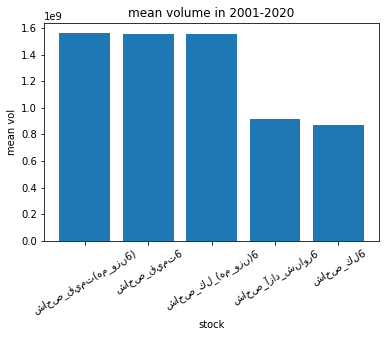

In [53]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [54]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DTYYYYMMDD,OPEN,HIGH,LOW,CLOSE,VOL,VAL,NUM_OF_TRANSACTIONS,CLOSE_ONE_DAY_BEFORE
3004878,شاخص_قيمت(هم_وزن6),20150224,9198.4,9181.8,9181.8,9181.8,278521094,6.199195e+11,31899,592.6
3004879,شاخص_قيمت(هم_وزن6),20150225,9183.3,9109.1,9109.2,9109.1,271188153,5.908300e+11,28391,21957.9
3004880,شاخص_قيمت(هم_وزن6),20150228,9111.9,9090.0,9090.0,9090.0,257849083,4.914391e+11,23864,590.0
3004881,شاخص_قيمت(هم_وزن6),20150301,9014.4,9030.4,9009.0,9030.4,475683577,1.030119e+12,37612,21635.1
3004882,شاخص_قيمت(هم_وزن6),20150302,9034.4,9043.5,9034.4,9043.5,717632564,9.735307e+11,39724,588.2


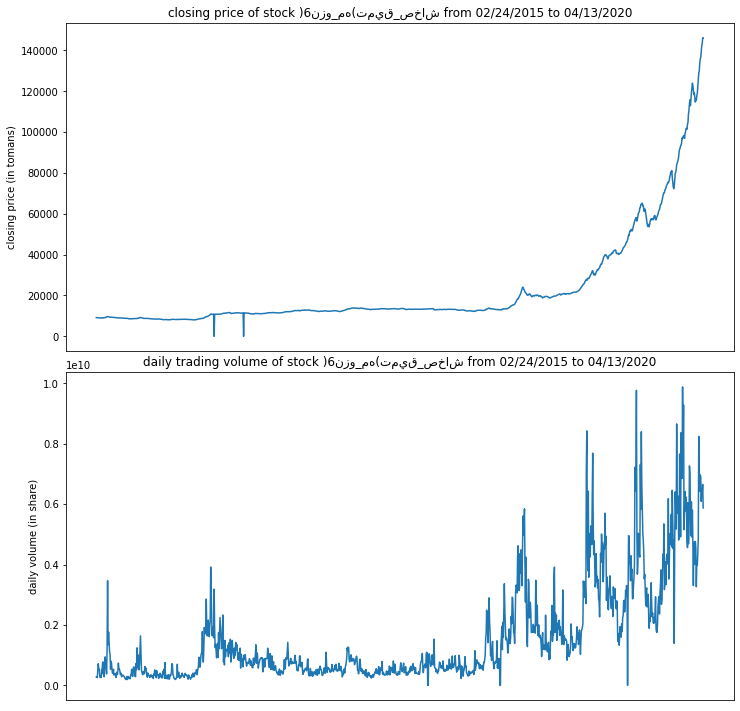

In [59]:
from datetime import datetime

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DTYYYYMMDD'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DTYYYYMMDD'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])
starting_date_object = datetime.strptime(starting_date,'%Y%m%d')
ending_date_object = datetime.strptime(ending_date,'%Y%m%d')
starting_date_in_new_format = starting_date_object.strftime('%m/%d/%Y')
ending_date_in_new_format = ending_date_object.strftime('%m/%d/%Y')

ax1.plot(data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
# ax1.xticks([], labels=" ")
ax2.plot(data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
plt.xticks([], labels="")
plt.show()

In [56]:
data.groupby('TICKER').agg({'DTYYYYMMDD': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DTYYYYMMDD', 'count'), ascending=False).head(10)

TICKER DTYYYYMMDD                           VOL
                   min       max count          mean
1616  وپترو   20010325  20200413  4366  2.323352e+06
1522  وساخت   20010325  20200413  4356  1.464725e+06
56    آريان   20101006  20200413  4347  2.723661e+06
624   خودرو   20010325  20200413  4340  1.123416e+07
1539   وسپه   20010327  20200413  4323  2.620691e+06
753   زنجان   20110105  20200413  4318  9.637195e+05
567   خبهمن   20010407  20200413  4315  6.061205e+06
1603  ونيكي   20010407  20200413  4302  1.712802e+06
900   شاراك   20010327  20200413  4298  2.342162e+06
1474  وبشهر   20010325  20200413  4291  2.265908e+06